# Modelo integra-e-dispara simplificado

A implementação do modelo integra e dispara simplificado deriva da modelagem matemática do neurônio como um **circuito RC**. A membrana neuronal exerce o papel de capacitor e os canais iônicos papel semelhante a um resistor. A manutenção do potencial de repouso se dá pelas bombas de sódio e potássio, que podem se prestar ao papel de uma bateria.

## Dinâmica

A dinâmica desse modelo, com enfoque no potencial de membrana, tem como resultado uma dinâmica linear:
$$
\frac{dV}{dt} = a(V - V_\text{rep}) \quad | \quad a < 0
$$

> Quanto mais distante o estímulo está do potencial de repouso, mais brusco é o retorno ao potencial. Porém todos retornam a uma taxa constante.

A determinação da constante $a$ pode ser feita por meio experimental, mas é possível obter um resultado mais preciso ao considerar o produto da capacitância da membrana e a resistência -> $RC$. Esse produto é conhecido como **constante temporal de membrana**. A constante temporal define o taxa de decaímento ou crescimento.Também pode ser denotada pela letra $\tau$
$$
\frac{dV}{dt} = -\frac{V - V_\text{rep}}{RC} = -\frac{V - V_\text{rep}}{\tau}
$$


Outro ponto a ser levado em consideração é a composição da constante $V_\text{rep}$ que corresponde ao pontencial de repouso da membrana. Essa constante na verdade pode ser modificada caso o neurônio receba estímulos, como PIPS e PEPS, levando o neurônio a um novo patamar de repouso o quanto o estímulo durar. Portanto torna-se conveniente adotar uma nova constante, conhecida como $V_\infty$:
$$
V_\infty = V_\text{rep} + E_r
$$

Onde $E_r$ é o potencial do estímulo aplicado a membrana.

## Resolução pelo método de euler

<IPython.core.display.Javascript object>


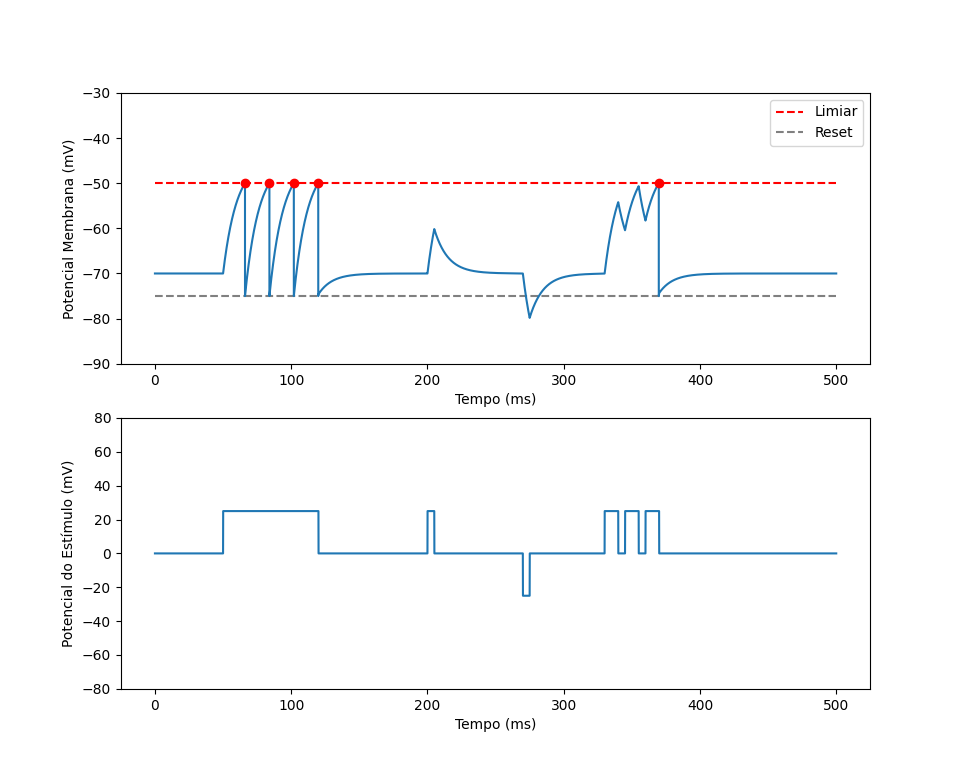

In [22]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt

# Derivada da eq. de membrana
def dt_eq_membrana(V,Vrep,Er,R,C):
    return -(V - (Vrep + Er))/R*C


# Integra e dispara método de Euler
def integra_dispara_euler(func, y0=-65, h=0.01, passos=1000, pulsos = [], limiar=-50, reset=-75, R=1,C=1):
    t = np.zeros(passos)  # Array para valores do tempo t_i 
    y = np.zeros(passos)  # Array para valores dos potenciais V_i
    I = np.zeros(passos) # Array para os estímulos aplicados a membrana
    disparos = [] #Array para guardar os disparos
    
    for pulso in pulsos:
        I[pulso['t_i']*int(1/h):pulso['t_f']*int(1/h)] = pulso['V']
            
    y[0] = y0
    for i in range(passos - 1): 
        t[i + 1] = t[i] + h 
        if y[i] >= limiar:
            disparos.append(i)
            y[i+1] = reset
        else:
            y[i + 1] =  y[i] + h*func(y[i], y0, I[i], R, C)

            

    return t, y, disparos, I

# Constantes de membrana
R = 10
C = 1
Vreset = -75
Vrep = -70
Vlim = -50

# Pulsos retangulares aplicados sobre a membrana
# t_i - tempo inicial
# t_f - tempo final
# V - potencial do pulso

pulsos_retangulares = [{'t_i': 50,'t_f': 120, 'V':25},
                       {'t_i': 200,'t_f': 205, 'V':25},
                       {'t_i': 270,'t_f': 275, 'V':-25},
                       {'t_i': 330,'t_f': 340, 'V':25},
                       {'t_i': 345,'t_f': 355, 'V':25},
                       {'t_i': 360,'t_f': 370, 'V':25}
                      ]

# Simulação
t, V, disparos, I = integra_dispara_euler(
    dt_eq_membrana, y0=Vrep, reset=Vreset, limiar=Vlim, pulsos=pulsos_retangulares, passos=50000, R=R, C=C)

# Plota gráfico com resultado do modelo
figure, axis = plt.subplots(2)
axis[0].set_ylim([-90, -30])
axis[0].set_xlabel("Tempo (ms)")
axis[0].set_ylabel("Potencial Membrana (mV)")
axis[0].plot(t, V, '-')
axis[0].plot(t[disparos], V[disparos], 'or')
axis[0].hlines(-50, 0, 500, linestyle='dashed', color="red", label="Limiar")
axis[0].hlines(-75, 0, 500, linestyle='dashed', color="grey", label="Reset")
axis[0].legend()

# Plota gráfico dos estímulo
axis[1].set_ylim([-80, 80])
axis[1].set_xlabel("Tempo (ms)")
axis[1].set_ylabel("Potencial do Estímulo (mV)")
axis[1].plot(t, I)



## Curva $F(I)$ empírica

A curva $F(I)$ corresponde a taxa de disparos dado certo estímulo:
$$
F(I) = \frac{\text{Taxa Disparos}}{\text{Estímulo}}
$$

Uma forma de se encontrar a curva $F(I)$ é através da aplicação de pulsos retangulares longos, como duração de 1 segundo. Esses pulsos devem ter duração constante, mas devem variar sua tensão a cada simulação, a fim de se obter todas as relações entre intensidade do estímulo e taxa de disparo.

### Simulação de curva $F(i)$ para estímulos de duração de 1 segundo

<IPython.core.display.Javascript object>


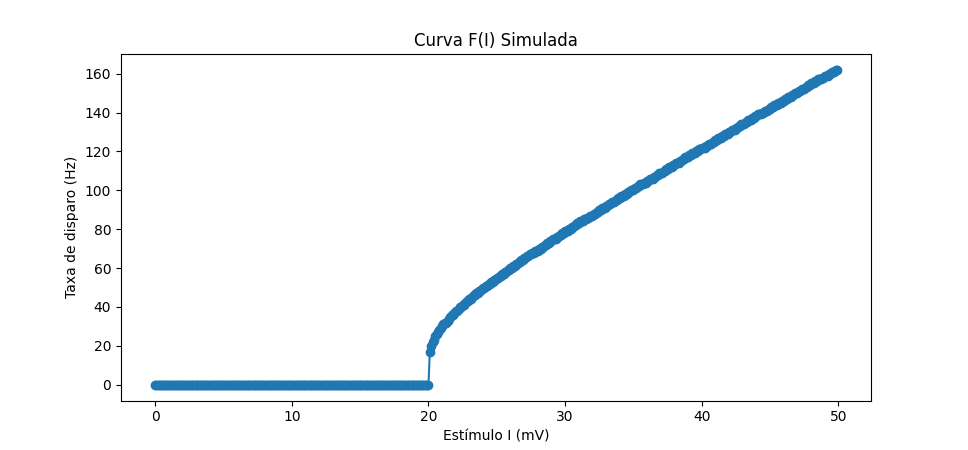

In [9]:
# Curva fi simulada
def curva_fi(h0, passos_est):
    """Integra curva F(I) para o modelo integra e dispara
        
        Est0 -- Valor em mV do estímulo inicial
        h0 -- Passo de integração, ou quanto o estímulo irá avançar a cada passo
        passos_est -- Total de passos que serão avançados
        
        Retorna Freq = frequência, I = Estímulos
    """
    Est = np.zeros(passos_est)
    Freq = np.zeros(passos_est)
    
    for i in range(passos_est):
        Est[i] = h0*i
        # Pulso
        pulsos_retangular = [{'t_i': 10,'t_f': 1000, 'V':Est[i]}]
            
        # Simulação
        t, V, disparos, I = integra_dispara_euler(
            dt_eq_membrana, y0=-70, reset=-75, limiar=-50, pulsos=pulsos_retangular, passos=100000, R=10, C=1)
        
        Freq[i] = len(disparos)

    return Freq, Est

Freq_sim, Est_sim = curva_fi(0.1, 500)


plt.figure(3)
plt.xlabel("Estímulo I (mV)")
plt.ylabel("Taxa de disparo (Hz)")
plt.title("Curva F(I) Simulada")
plt.plot(Est_sim, Freq_sim, 'o-')

<IPython.core.display.Javascript object>


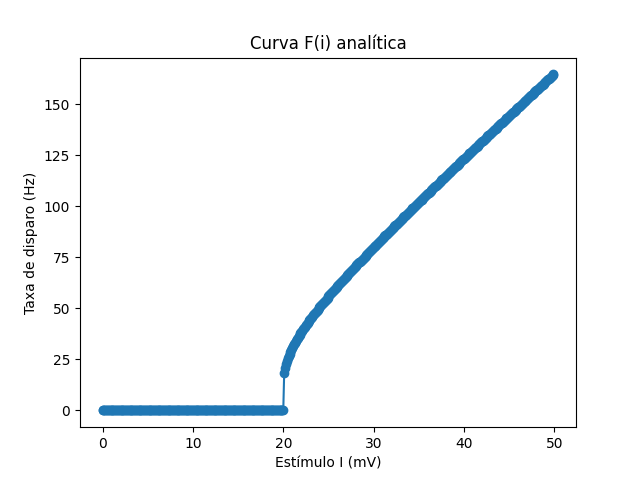

In [14]:
from math import log
# Curva fi analitica
def eq_curva_fi(tau, Vrep, Vest, Vreset, Vlim):
    Vinf = Vrep + Vest
    if(Vinf > Vlim):
        return 1/(tau*log( (Vinf - Vreset) / (Vinf - Vlim) ))
    else:
        return 0

def curva_fi_analitica(h0, passos_est):
    Est = np.zeros(passos_est)
    Freq = np.zeros(passos_est)
    
    for i in range(passos_est):
        Est[i] = h0*i
            
        # Simulação
        Freq[i] = eq_curva_fi(tau=10, Vrep=-70, Vreset=-75, Vlim=-50, Vest=Est[i]) * 1000
        
    return Freq, Est

Freq_anal, Est_anal = curva_fi_analitica(0.1, 500)


plt.figure(4)
plt.xlabel("Estímulo I (mV)")
plt.ylabel("Taxa de disparo (Hz)")
plt.title("Curva F(i) analítica")
plt.plot(Est_anal, Freq_anal, 'o-')

## Comparação entre soluções analíticas e soluções simuladas

<IPython.core.display.Javascript object>


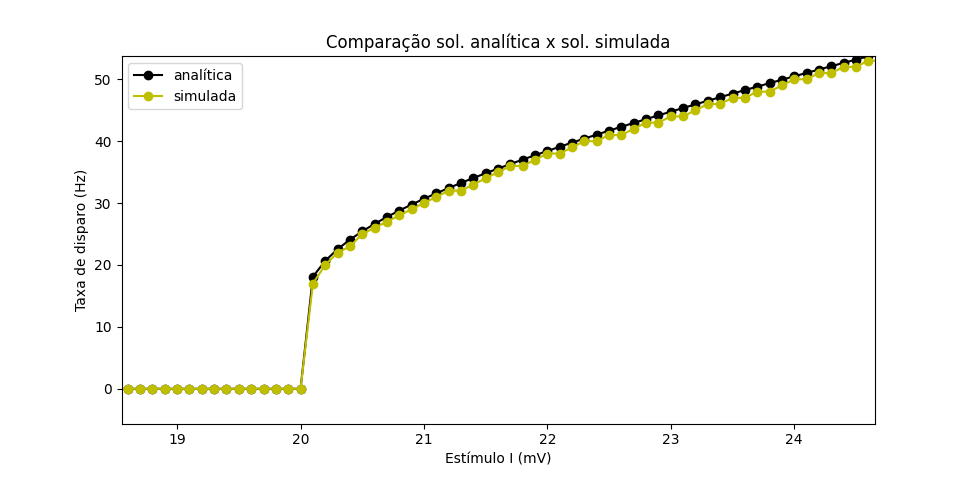

In [11]:
plt.figure(5)
plt.title("Comparação sol. analítica x sol. simulada")
plt.xlabel("Estímulo I (mV)")
plt.ylabel("Taxa de disparo (Hz)")
plt.plot(Est_anal, Freq_anal, 'o-k', label="analítica")
plt.plot(Est_sim, Freq_sim, 'o-y', label="simulada")
plt.legend()